<a href="https://colab.research.google.com/github/119020/NLP_2025_Spring_Materials/blob/main/CUHK_RA_TASK/NLP_Task1_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Task 1: Topic Model
**CUHK RA Recruitment:** Technical Task Sheet
for Prof. Ling Cen (2025)





*Please enter your personal information (make sure you have copied this colab)*

**Name**: 匡博文 KUANG, Bowen

**Institution**: The Chinese University of Hong Kong, Shenzhen

**Student ID**: 119020237






In [ ]:
# Google Colab
# Using T4 GPU

1. **Make a copy of the provided Google Colab file.**  
   First, you need to make a copy of the provided file into your own Google Drive. To accomplish this, open the Colab file link, navigate to `File` → `Save a copy in Drive`.

2. **Execute the notebook to generate results.**  
   You can click on "Connect to GPU" to apply for a free T4 GPU. Then, you can press the large play button to run a code cell.

For more detailed instructions, refer to [Working with Google Colab](https://docs.google.com/document/d/1vMe8kC-oSyP3w7rIurDbG3NqfyQw7sZJ2C_S2ngtQnk/edit?usp=sharing).

In [1]:
import json
import pandas as pd
from sentence_transformers import SentenceTransformer

# 可选：启用OpenMP并行（需安装）
#import os
#os.environ["OMP_NUM_THREADS"] = "4"  # 设为CPU物理核心数

!wget -O content_samples.jl -qq --no-check-certificate "https://drive.usercontent.google.com/u/0/uc?id=1s_k8Gs7ZqYuRgGYPSlgUUN27G32zeKc-&export=download"

In [2]:
# 读取数据
data = []
with open('content_samples.jl', 'r') as f:
    for line in f:
        sample = json.loads(line)
        content = sample.get('Content', '')
        Time = sample.get('time', '')
        year = int(Time.split('-')[0]) if Time else None
        name = sample.get('Name', '')
        data.append({'content': content, 'year': year, 'name': name})

df = pd.DataFrame(data)
df
#df = df.sample(frac=0.02, random_state=42)# 0.02*112425

,content,year,name
0,"Karen, the turnover rates or retention rates ...",2001,THOMAS B. GOLISANO
1,It is safe to say that they declined fairly s...,2001,NATHAN SARKISIAN
2,"We don't forecast, we order, all right, and s...",2001,JOHN DAANE
3,Okay next for John. John on the MPLD product ...,2001,TIM MAHON
4,Since a very small amount of dollars that are...,2001,KENDA GONZALEZ
...,...,...,...
112420,And does that -- how do you see the market ch...,2003,Thad Piper
112421,"Yes, I wanted to get some direction as to whe...",2003,Rizwan Ali
112422,"If you did something with that, could you sor...",2003,Michael Fuller
112423,"Real quick, given first quarter FFO, and som...",2004,Mike Mueller


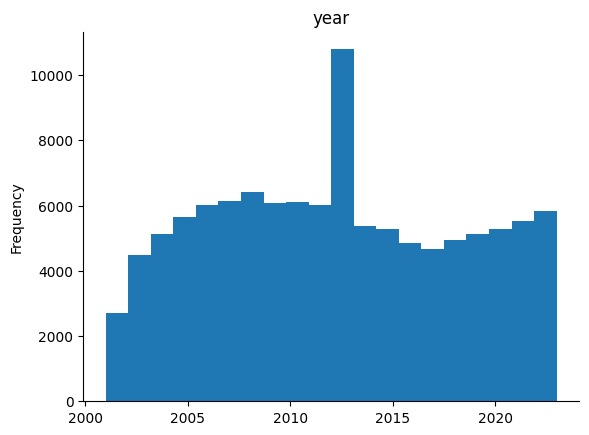

In [3]:
from matplotlib import pyplot as plt
df['year'].plot(kind='hist', bins=20, title='year')
plt.gca().spines[['top', 'right',]].set_visible(False)

1. Tokenize and lower-case texts.

In [5]:
!pip -qq install nltk==3.8
import re
import spacy
#from nltk.corpus import stopwords
import nltk
from nltk.corpus import stopwords # 一定要import!!!
nltk.download('stopwords')

# 加载语言模型
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
stop_words = set(stopwords.words('english')) | {'company', 'inc', 'ltd'}  # 自定义停用词

def enhanced_clean(text):
    # 去除HTML标签
    text = re.sub(r'<[^>]+>', '', text)
    # 移除特殊字符（保留基本标点）
    text = re.sub(r'[^a-zA-Z0-9\s.,;:!?]', '', text)
    # 词形还原
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    # 过滤停用词和短词
    return ' '.join([word.lower() for word in lemmas
                    if word.lower() not in stop_words and len(word) > 2])

# 应用清洗（约11分钟）
df['cleaned_content'] = df['content'].apply(enhanced_clean)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
df

,content,year,name,cleaned_content
0,"Karen, the turnover rates or retention rates ...",2001,THOMAS B. GOLISANO,karen turnover rate retention rate client majo...
1,It is safe to say that they declined fairly s...,2001,NATHAN SARKISIAN,safe say decline fairly significantly
2,"We don't forecast, we order, all right, and s...",2001,JOHN DAANE,forecast order right soon order soon ship nath...
3,Okay next for John. John on the MPLD product ...,2001,TIM MAHON,okay next john john mpld product line talk lit...
4,Since a very small amount of dollars that are...,2001,KENDA GONZALEZ,since small amount dollar allocate university ...
...,...,...,...,...
112420,And does that -- how do you see the market ch...,2003,Thad Piper,see market change talk long time would happen ...
112421,"Yes, I wanted to get some direction as to whe...",2003,Rizwan Ali,yes want get direction think data service reve...
112422,"If you did something with that, could you sor...",2003,Michael Fuller,something could sort say time could actually d...
112423,"Real quick, given first quarter FFO, and som...",2004,Mike Mueller,real quick give first quarter ffo acquisition ...


## Task 1.1
Encode Content into embeddings using large language models (LLMs)

In [ ]:
# 使用Google Colab T4-GPU
#model = SentenceTransformer('all-MiniLM-L6-v2', device='cuda') # 1min 30s
model = SentenceTransformer('paraphrase-mpnet-base-v2')# 3min 30s

import time
start = time.time()
embeddings = model.encode(df['cleaned_content'], batch_size=32, convert_to_numpy=True, show_progress_bar=True)
print(f"Processed samples in {time.time()-start:.2f}s")
df['embedding'] = list(embeddings)

df

Batches:   0%|          | 0/3514 [00:00<?, ?it/s]

Processed samples in 202.65s


,content,year,name,cleaned_content,embedding
0,"Karen, the turnover rates or retention rates ...",2001,THOMAS B. GOLISANO,karen turnover rate retention rate client majo...,"[-0.04290884, -0.10484238, -0.002086425, -0.11..."
1,It is safe to say that they declined fairly s...,2001,NATHAN SARKISIAN,safe say decline fairly significantly,"[-0.19678842, 0.14910743, -0.14726874, 0.01674..."
2,"We don't forecast, we order, all right, and s...",2001,JOHN DAANE,forecast order right soon order soon ship nath...,"[-0.077177286, 0.045190193, -0.037587013, -0.0..."
3,Okay next for John. John on the MPLD product ...,2001,TIM MAHON,okay next john john mpld product line talk lit...,"[-0.04926885, -0.12857193, -0.03496225, 0.0016..."
4,Since a very small amount of dollars that are...,2001,KENDA GONZALEZ,since small amount dollar allocate university ...,"[0.05902453, -0.07379501, 0.007883683, 0.00939..."
...,...,...,...,...,...
112420,And does that -- how do you see the market ch...,2003,Thad Piper,see market change talk long time would happen ...,"[0.09263611, 0.3230551, -0.05187889, 0.0056008..."
112421,"Yes, I wanted to get some direction as to whe...",2003,Rizwan Ali,yes want get direction think data service reve...,"[-0.019103838, 0.08588112, -0.073319405, -0.05..."
112422,"If you did something with that, could you sor...",2003,Michael Fuller,something could sort say time could actually d...,"[-0.077429175, 0.09369802, -0.030527191, 0.057..."
112423,"Real quick, given first quarter FFO, and som...",2004,Mike Mueller,real quick give first quarter ffo acquisition ...,"[0.039935924, 0.0029530525, -0.009741188, -0.0..."


## Task 1.2
Use more than two methods to identify most top 20 frequently discussed hot topics of the
questions of each 4 years ([2000, 2003], [2004, 2007], . . . , [2020, 2022]).

In [ ]:
!pip -qq install bertopic

import numpy as np
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.3 MB/s eta 0:00:00


In [ ]:
# 定义时间段生成函数
def get_periods(start=2000, end=2022):
    periods = []
    current = start
    while current <= end:
        next_end = current + 3
        if next_end > end:
            next_end = end
        periods.append((current, next_end))
        current = next_end + 1
    return periods

periods = get_periods()


# 对每个时间段进行分析 (执行时间：预计8分钟)
for start, end in periods:
    mask = (df['year'] >= start) & (df['year'] <= end)
    period_df = df[mask]
    texts = period_df['cleaned_content'].tolist()

    # 方法1: LDA
    vectorizer = CountVectorizer(max_features=2000)
    X = vectorizer.fit_transform(texts)
    lda = LatentDirichletAllocation(n_components=20, random_state=42)
    lda.fit(X)

    # 提取LDA主题词
    feature_names = vectorizer.get_feature_names_out()
    lda_topics = []
    for idx, topic in enumerate(lda.components_):
        top_words = [feature_names[i] for i in topic.argsort()[-10:]]
        lda_topics.append(f"Topic {idx}: {', '.join(top_words)}")

    # 方法2: BERTopic
    embeddings_period = np.stack(period_df['embedding'].values)
    topic_model = BERTopic()
    topics, _ = topic_model.fit_transform(texts, embeddings_period)

    # 获取BERTopic结果
    bert_topics = []
    for topic_num in set(topics):
        if topic_num != -1:
            words = topic_model.get_topic(topic_num)
            bert_topics.append(f"Topic {topic_num}: {', '.join([w[0] for w in words[:5]])}")

    print(f"Period {start}-{end}:")
    print("LDA Topics:", lda_topics[:5])
    print("BERTopic Topics:", bert_topics[:5])


Period 2000-2003:
LDA Topics: ['Topic 0: look, see, would, like, make, get, mean, think, term, know', 'Topic 1: get, would, million, say, two, question, first, second, half, year', 'Topic 2: contract, sure, hear, backlog, million, say, would, okay, yes, right', 'Topic 3: would, say, tax, one, enough, see, question, number, sorry, fair', 'Topic 4: would, first, second, think, look, year, last, third, fourth, quarter']
BERTopic Topics: ['Topic 0: thank, marcia, susan, lou, phil', 'Topic 1: okay, thank, 103, perfect, alright', 'Topic 2: okay, alright, catalogue, laughter, park', 'Topic 3: patient, fda, hospital, study, clinical', 'Topic 4: margin, gross, improvement, quarter, high']
Period 2004-2007:
LDA Topics: ['Topic 0: final, get, okay, sure, ill, back, one, question, yes, right', 'Topic 1: hear, gentleman, question, thank, quarter, congratulation, afternoon, guy, morning, good', 'Topic 2: loan, america, speaker, market, europe, north, multiple, look, think, growth', 'Topic 3: guidanc

## Task 1.3
Use one method in Task 1.2. to identify the analysts who discussed these hot topics.

In [ ]:
from collections import defaultdict
import pandas as pd

# 使用BERTopic结果进行分析（前5个topic对应的analysts）
for start, end in periods:
    mask = (df['year'] >= start) & (df['year'] <= end)
    period_df = df[mask]
    texts = period_df['cleaned_content'].tolist()
    embeddings_period = np.stack(period_df['embedding'].values)

    topic_model = BERTopic()
    topics, _ = topic_model.fit_transform(texts, embeddings_period)
    period_df['topic'] = topics

    analyst_topics = defaultdict(list)
    for _, row in period_df.iterrows():
        if row['topic'] != -1:
            analyst_topics[row['topic']].append(row['name'])

    print(f"Period {start}-{end} Analyst Participation:")
    for topic in sorted(set(topics)):
        if topic != -1 and topic < 5:
            names = analyst_topics[topic]
            counter = dict(pd.Series(names).value_counts().head(3))
            print(f"Topic {topic}: {counter}")

Period 2000-2003 Analyst Participation:
Topic 0: {'Analyst': np.int64(15), 'Unidentified Participant': np.int64(8), 'Kristine Koerber': np.int64(2)}
Topic 1: {'Analyst': np.int64(9), 'Gary Taylor': np.int64(2), 'John Herrlin': np.int64(2)}
Topic 2: {'Analyst': np.int64(5), 'David Smith': np.int64(2), 'CHARLES W. ERGEN': np.int64(1)}
Topic 3: {'Unidentified Participant': np.int64(5), 'Analyst': np.int64(4), 'Mark Landy': np.int64(3)}
Topic 4: {'Analyst': np.int64(8), 'James Stone': np.int64(2), 'Scott Flower': np.int64(2)}
Period 2004-2007 Analyst Participation:
Topic 0: {'Phil Nadeau': np.int64(7), 'Thomas Wei': np.int64(7), 'Mark Monane': np.int64(7)}
Topic 1: {'Dan Jenkins': np.int64(3), 'Eric Katzman': np.int64(3), 'Joseph Craigen': np.int64(2)}
Topic 2: {'Jon Hickman': np.int64(3), 'David Leiker': np.int64(3), 'Robert Maire': np.int64(3)}
Topic 3: {'Jo Walton': np.int64(3), 'Christine Augustine': np.int64(3), 'Michael Rollins': np.int64(2)}
Topic 4: {'Budd Bugatch': np.int64(3), 'S